### Features' Partial Dependence Plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


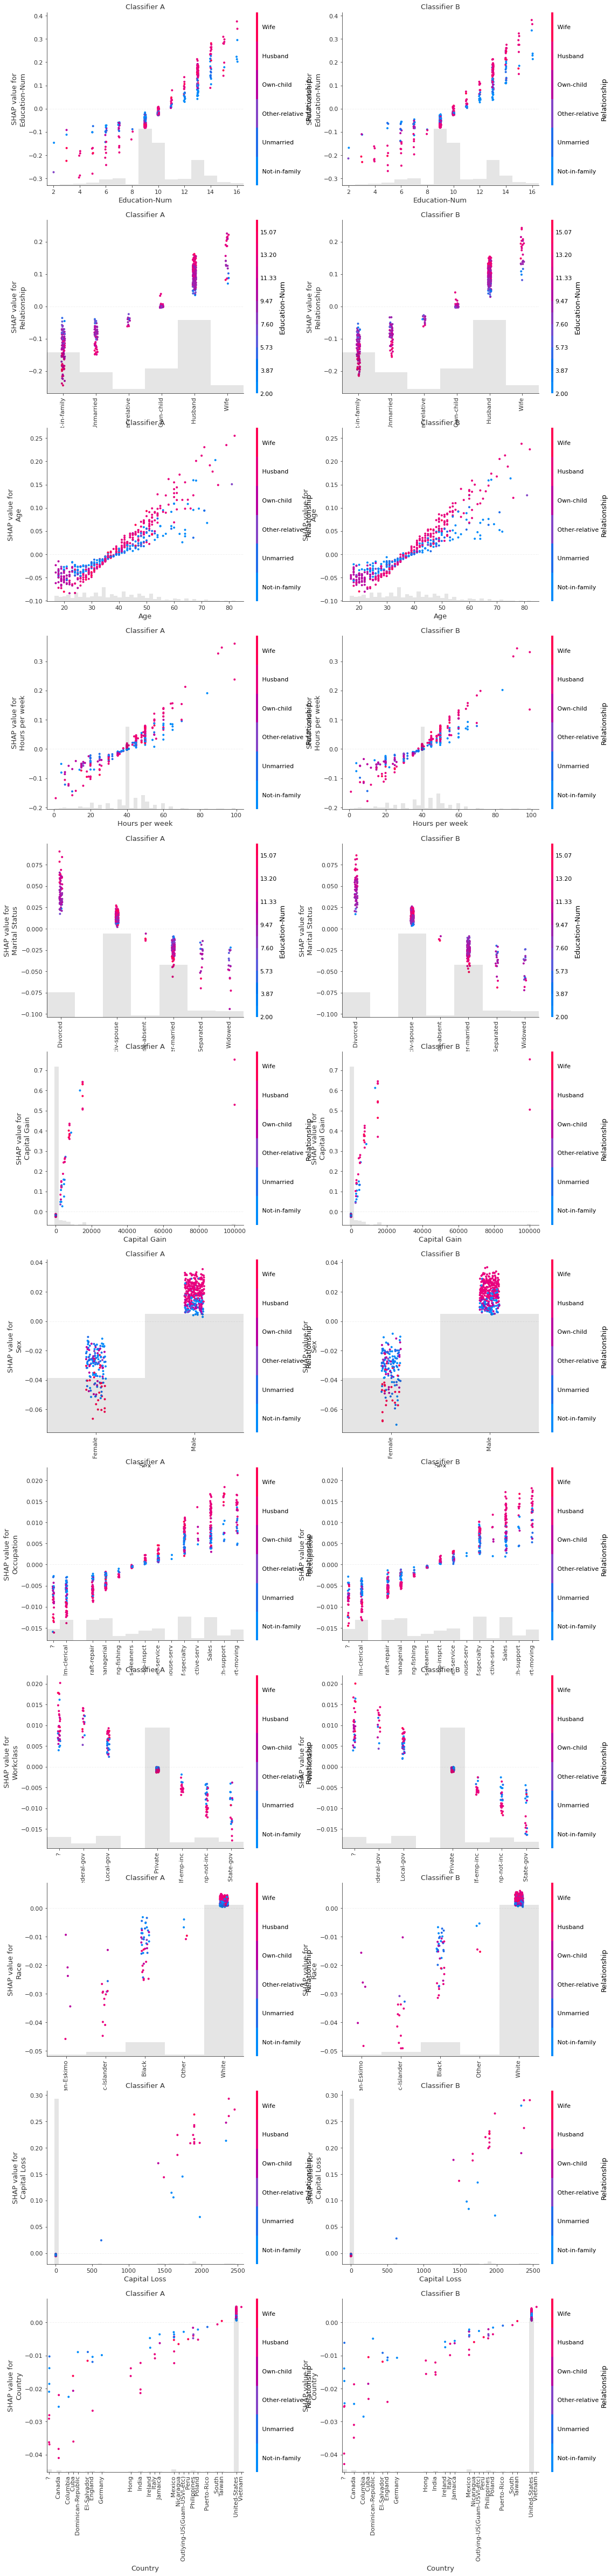

In [26]:
n_columns = 2
n_rows = n_features
fig = pyplot.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in features_sorted:
    ax = fig.add_subplot(n_rows, n_columns, i)
    plot.shap_scatter(expl.proba.a, feature, 'Classifier A', ax=ax)
    plot.shap_scatter(expl.proba.b, feature, 'Classifier B', ax=fig.add_subplot(n_rows, n_columns, i+1, sharey=ax))
    i += n_columns
pyplot.show()